# Creating a Pneumonia X-ray Classifier

Images are extracted from: 
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
Author           : Darren Scott Hinde
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images using Custom Deep Convololutional Neural Network and by                         retraining pretrained model “InceptionV3” with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and fine-tuned model for 
                      two new label classes (Pneumonia and Normal).
                   3. With Custom Deep Convololutional Neural Network attained testing accuracy 89.53% and loss 0.41.

In [1]:
import os, math, json
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.14.0


## Check that our gpu is being used instead of CPU

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
from glob import glob
from sklearn.model_selection import train_test_split

In [9]:
#see all the files are in the correct folder
filenames = glob("data/input/train/NORMAL/*.jpeg")


### Splitting the data

In [9]:
VALIDATION_SPLIT = 0.2

#Glob grabs all images in the assocaited directory and forms an array
normal_dir = glob("data/input/train/NORMAL/*.jpeg")
C = glob("data/input/train/PNEUMONIA/*.jpeg")

#split the data into training and testing
normal_train, normal_test = train_test_split(normal_dir, test_size=VALIDATION_SPLIT)
pneumonia_train, pneumonia_test = train_test_split(pneumonia_dir, test_size=VALIDATION_SPLIT)

TRAIN_DIR = 'data/input/train'
TEST_DIR = 'data/input/test'


#### Plot some images from the dataset

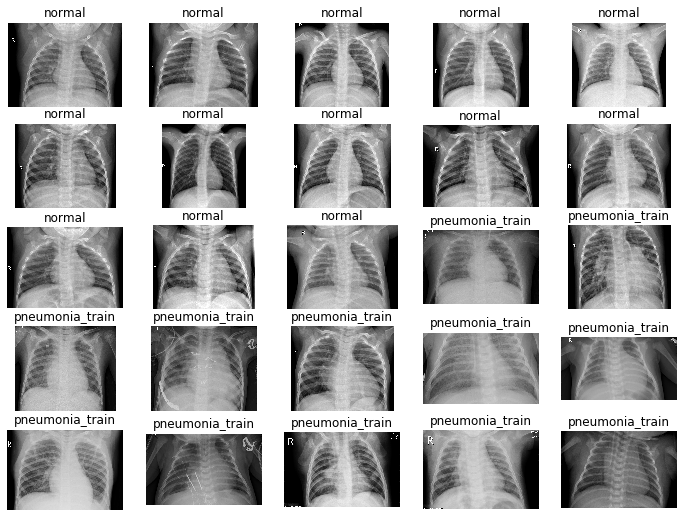

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#grabs 13 random images from the normal_train array
normal = np.random.choice(normal_train, 13)
pneumonia = np.random.choice(pneumonia_train, 12)
data = np.concatenate((normal, pneumonia_train))
labels = 13 * ['normal'] + 12 *['pneumonia_train']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
#we plot the images from above that were signed into data and labels
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Model Customization

Due to some compatability issues we are using tensorflow version 1. 

Here we get the Inception_v3 model from Keras and we will use it todo transfer learning. 
We will also have to add our final layer to the model . 

In [28]:
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import InceptionV3

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


CLASSES = 2
    
# setup model

#IMPORTING THE MODEL
#model = load_model("inception-v3/inception_v3.ckpt")
base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')
#base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
#Do not allow other layers of the model to be trainable only our new layer
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Data Augmentation

We alter the image slightly to comensate for nto direct xrays, however on the first attempt we made the images too diverse which affected the result and overfitting occured. To prevent this we reduce the impact of the variantions this should also reflect real world senarios as xrays should not be too varied. 

In [37]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32
#was 0.4
ROTATION_RANGE = 10  
#was 0.2
pRANGE = 0.05     


# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=ROTATION_RANGE,
    width_shift_range=pRANGE,
    height_shift_range=pRANGE,
    shear_range=pRANGE,
    zoom_range=pRANGE,
    horizontal_flip= False , #True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=ROTATION_RANGE,
    width_shift_range=pRANGE,
    height_shift_range=pRANGE,
    shear_range=pRANGE,
    zoom_range=pRANGE,
    horizontal_flip=False , #True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Plot some results
Here we generate our own warped images to prevent overfitting

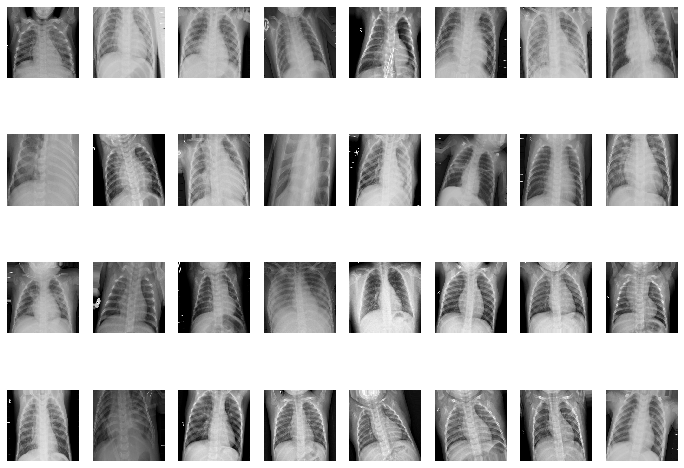

In [39]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

In [40]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'xRay_pneumonia_classifier.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 379s 1s/step - loss: 0.3008 - accuracy: 0.8680 - val_loss: 0.7852 - val_accuracy: 0.6825
Epoch 2/5
320/320 [==============================] - 377s 1s/step - loss: 0.2212 - accuracy: 0.9097 - val_loss: 0.9574 - val_accuracy: 0.6370
Epoch 3/5
320/320 [==============================] - 375s 1s/step - loss: 0.2100 - accuracy: 0.9167 - val_loss: 1.8238 - val_accuracy: 0.6350
Epoch 4/5
320/320 [==============================] - 382s 1s/step - loss: 0.2005 - accuracy: 0.9215 - val_loss: 1.1137 - val_accuracy: 0.6355
Epoch 5/5
320/320 [==============================] - 403s 1s/step - loss: 0.2042 - accuracy: 0.9222 - val_loss: 0.3616 - val_accuracy: 0.6673


In [44]:
print(history.history)

{'val_loss': [0.7851516008377075, 0.9573850035667419, 1.8237526416778564, 1.1137338876724243, 0.36155635118484497], 'val_accuracy': [0.6825000047683716, 0.6370000243186951, 0.6349999904632568, 0.6355000138282776, 0.6673387289047241], 'loss': [0.30076477334368973, 0.22115882239304482, 0.21003792085684836, 0.20050725458422675, 0.20417343061417342], 'accuracy': [0.86796874, 0.90966797, 0.91669923, 0.92148435, 0.92216796]}


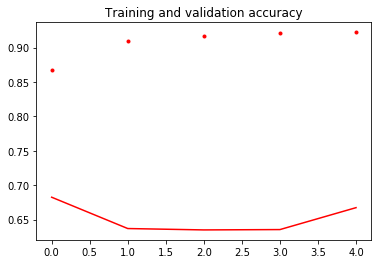

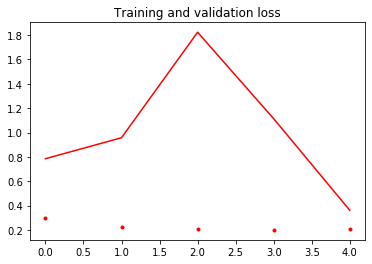

In [46]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

    

plot_training(history)

## Prediction of the custom Model

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("normal", "pneumonia")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [48]:
model = load_model(MODEL_FILE)

[0.03507236 0.9649276 ]


array([0.03507236, 0.9649276 ], dtype=float32)

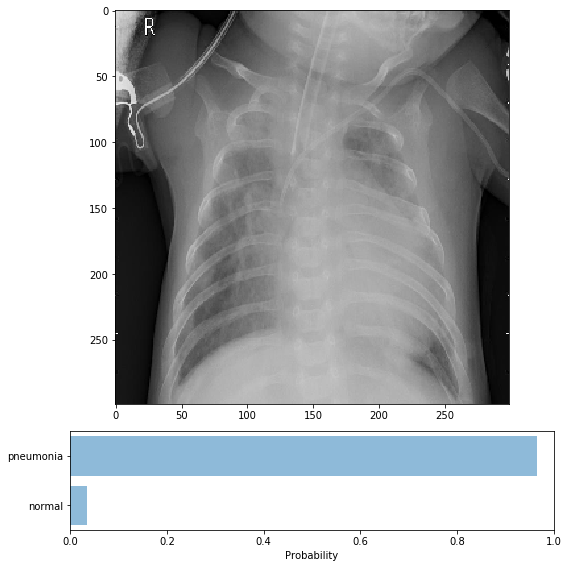

In [49]:
img = image.load_img('data/input/test/PNEUMONIA/person1_virus_6.jpeg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

print(preds)

plot_preds(np.asarray(img), preds)
preds

array([0.74281573, 0.25718427], dtype=float32)

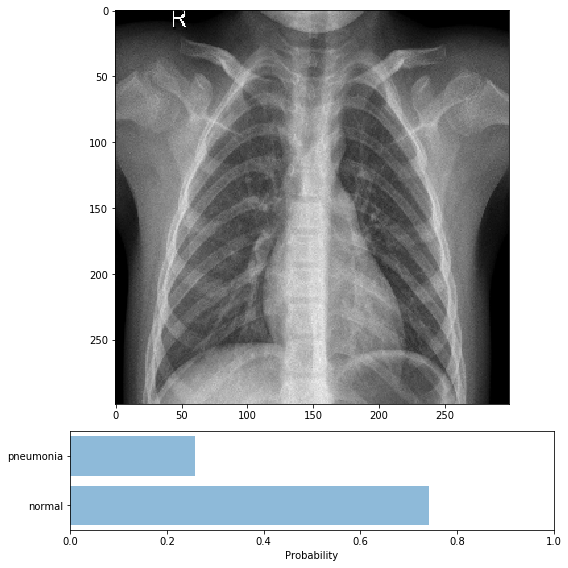

In [50]:
img = image.load_img('data/input/test/NORMAL/IM-0030-0001.jpeg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([0.6747368 , 0.32526317], dtype=float32)

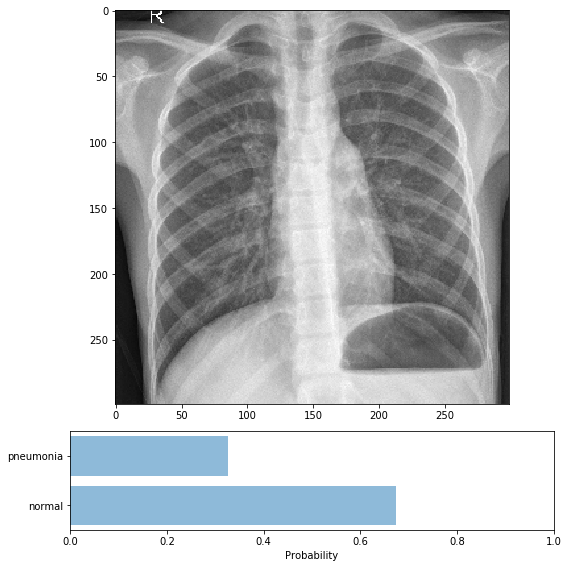

In [51]:
img = image.load_img('data/input/test/NORMAL/IM-0033-0001.jpeg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

We can see our model is correctly predicting the if the image is either PNEUMONIA or normal. 